## This assignment is a backbone implementaion of https://arxiv.org/abs/1812.00328

Through this exercise, you will be familar with:

1. How to backpropagate across a data processing module that uses non-differentiable functions.
2. How to vectorize codes for GPU friendly processing.
3. How to deal with nested optimization in PyTorch possibly making use of gradient stop, such as torch.no_grad().
4. How to mix CNNs with other modules in an end-to-end optimization.

## Do not edit next cell

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.tensorboard import SummaryWriter
import timeit
import scipy
from scipy.stats.distributions import truncnorm
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0


## Do not edit next cell

In [0]:
# Define hyper parameters, models, and functions

# A few hyper parameters
delta = 2 # for cost function, acts as smoothing contour
nLines = 50 # number of radial lines
nfilters=16 # number of filters to be used in the network model

# Star pattern computation
def star_pattern():
  theta = np.arange(0.0,2*math.pi,2*math.pi/nLines,dtype=np.float32)
  rad = np.arange(10.0,50.0,1.0)

  RADIUS, THETA = np.meshgrid(rad,theta)

  yx0 = np.reshape([140.0,160.0],(1,2))
  X = yx0[0,1] + RADIUS*np.cos(THETA)
  Y = yx0[0,0] + RADIUS*np.sin(THETA)
  return X,Y


# A few one-time placeholder arrays including the star pattern

X,Y = star_pattern()

X = torch.tensor(X.astype(np.float32)).to(device)
Y = torch.tensor(Y.astype(np.float32)).to(device)

N,M = X.shape

U = torch.zeros((N-1,M,M),dtype=torch.float32).to(device) # value function
I = torch.zeros((N-1,M,M),dtype=torch.int32).to(device) # index function
E = torch.zeros((N,M,M),dtype=torch.float32).to(device) # pairwise energy function
v = -torch.ones((N),dtype=torch.long).to(device) # solution vector

# Dynamic programming to compute indices of the star pattern
# This implements Algorithm 1 from https://arxiv.org/abs/1812.00328
def DynProg(U,I,E,v,warped_image,N,M,delta):

  maxval = torch.max(warped_image)-torch.min(warped_image) + 1.0
  E[:] = maxval

  """
  # Construct E taking into account gradient of warped image on two neiboring radial lines
  for i in range(M):
    jmin = max(0,i-delta)
    jmax = min(i+delta,M-1)
    E[:,i,jmin:jmax+1] = warped_image[0:N,i+1:i+2] - warped_image[0:N,i:i+1] + warped_image[1:N+1,jmin+1:jmax+2] - warped_image[1:N+1,jmin:jmax+1]
  """
  # An example vectorization for constructing E
  # this code uses a for loop with a smaller range (2*delta+1)
  # than the code above using a range M 
  i = torch.arange(0,M,1)
  for d in torch.arange(-delta,delta+1,1):
    j = torch.min(input=torch.max(input=i+d,other=torch.tensor(0)),other=torch.tensor(M-1))
    E.view(N,M*M)[:,M*i+j] = warped_image[0:N,i+1] - warped_image[0:N,i] + warped_image[1:N+1,j+1] - warped_image[1:N+1,j]

  # build value and index functions
  print(E.shape,"size E chande")
  print(U.shape,"size U chande")

  # this is the version with for loops
  for n in range(N-1):
    for i in range(M):
      for k in range(M):
        if n==0:
          U[n,i,k], I[n,i,k] = torch.min(E[0,i,:]+E[1,:,k],0)
        else:
          U[n,i,k], I[n,i,k] = torch.min(U[n-1,i,:]+E[n+1,:,k],0)

  # backtrack to find solution
  val=1e10
  for j in range(M):
    if val > U[N-2,j,j]:
      val = U[N-2,j,j]
      v[0] = j
  v[N-1] = I[N-2,v[0],v[0]]
  for n in np.arange(N-2,0,-1):
    v[n] = I[n-1,v[0],v[n+1]]

  return v

def WarpImage(image,X,Y,height,width):
  height,width = image.shape
  warped_image = torch.nn.functional.grid_sample(image.view(1,1,height,width),torch.stack([2.0*X/width-1.0,2.0*Y/height-1.0],2).unsqueeze(0)).squeeze()

  # increase the borders of the warped image a bit for spatial gradient computation
  warped_image = torch.cat((warped_image,warped_image[:,-1:]),1)
  warped_image = torch.cat((warped_image,warped_image[0:1,:]),0)
  
  return warped_image

# DenseNet type CNN to process input image
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, nfilters, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(nfilters+1, nfilters, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(2*nfilters+1, nfilters, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(3*nfilters+1, 1, kernel_size=3,padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(torch.cat((x,x1),dim=1)))
        x3 = F.relu(self.conv3(torch.cat((x,x1,x2),dim=1)))
        x4 = self.conv4(torch.cat((x,x1,x2,x3),dim=1))
        return x4


## Edit next cell to write your own vectorized dynamic programming

In [0]:
# Your code for vectorized dynamic programming
def DynProg_vectorized(U,I,E,v,warped_image,N,M,delta):
 
  maxval = torch.max(warped_image)-torch.min(warped_image) + 1.0
  E[:] = maxval

  i = torch.arange(0,M,1)
  for d in torch.arange(-delta,delta+1,1):
    j = torch.min(input=torch.max(input=i+d,other=torch.tensor(0)),other=torch.tensor(M-1))
    E.view(N,M*M)[:,M*i+j] = warped_image[0:N,i+1] - warped_image[0:N,i] + warped_image[1:N+1,j+1] - warped_image[1:N+1,j]

  # build value and index functions
  ##########vectorization process for n=0 and n>0
  ####### for n==0

  U= torch.zeros((N-1,M,M),dtype=torch.float32).to(device) # value function
  I= torch.zeros((N-1,M,M),dtype=torch.int32).to(device) # index function
  TRANS1, TRANS2= torch.min( torch.repeat_interleave( E[0,:,:], repeats=M, dim=0)+torch.cat(M*[E[1,:,:].t()]) , 1)
  U[0,:,:] =TRANS1.view(M,M) 
  I[0,:,:] =TRANS2.view(M,M) 

  ###### n>0

  for n in range(1,N-1,1):
      TRANS1, TRANS2 = torch.min( torch.repeat_interleave( U[n-1,:,:], repeats=M, dim=0)+torch.cat(M*[E[n+1,:,:].t()]) , 1)
      U[n,:,:] = TRANS1.view(M,M)
      I[n,:,:] = TRANS2.view(M,M)

   
  #########  
  # backtrack to find solution
  val=1e10
  for j in range(M):
    if val > U[N-2,j,j]:
      val = U[N-2,j,j]
      v[0] = j
  v[N-1] = I[N-2,v[0],v[0]]
  for n in np.arange(N-2,0,-1):
    v[n] = I[n-1,v[0],v[n+1]]

    
  return v

## Edit next cell to write your own CNN or neural network that approximates dynamic program function

In [0]:
# Your code for approximating CNN or NN for dynamic programming
# input must be warped image and output can be log(softmax) function
class ApproxNet(nn.Module):
  def __init__(self):
      super(ApproxNet, self).__init__()
      self.conv1 = nn.Conv2d(1, nfilters, kernel_size=3,padding=1)
      self.conv2 = nn.Conv2d(nfilters+1, nfilters, kernel_size=3,padding=1)
      self.conv3 = nn.Conv2d(2*nfilters+1, nfilters, kernel_size=3,padding=1)
      self.conv4 = nn.Conv2d(3*nfilters+1, 1, kernel_size=3,padding=1)
  
  def forward(self, x):
      x1 = F.relu(self.conv1(x))
      x2 = F.relu(self.conv2(torch.cat((x,x1),dim=1)))
      x3 = F.relu(self.conv3(torch.cat((x,x1,x2),dim=1)))
      x4 = self.conv4(torch.cat((x,x1,x2,x3),dim=1))
      return F.log_softmax(x4,dim=3)



## Only edit the path to the images in the next cell, nothing else

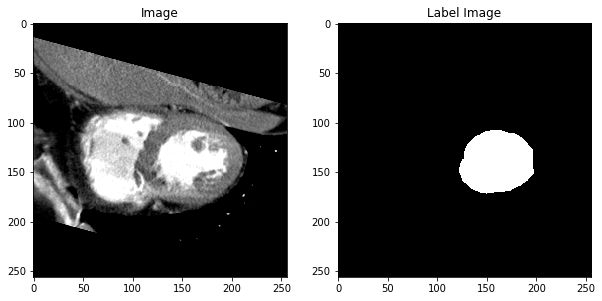

In [6]:
# read image and its label
image = io.imread("/content/drive/My Drive/assignement3/axial_CT_slice.bmp").astype(np.float32)
label_image = io.imread("/content/drive/My Drive/assignement3/axial_CT_slice_label.bmp").astype(np.float32)

image = torch.from_numpy(image).float().to(device)
label_image = torch.from_numpy(label_image).float().to(device)


height, width = label_image.shape # image height and width

%matplotlib inline
fig=plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(image.detach().cpu(),cmap='gray')
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(label_image.detach().cpu(),cmap='gray')
plt.title("Label Image")
plt.show()


## Do not edit next cell

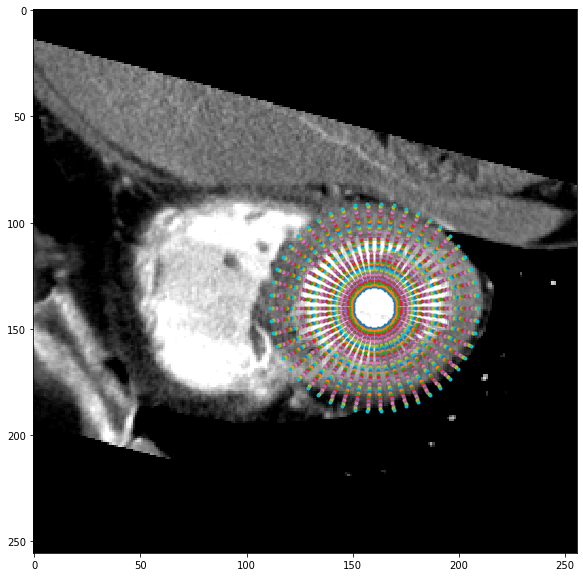

In [7]:
# visualize star pattern on input image
%matplotlib inline
fig=plt.figure(figsize=(10, 10))
plt.imshow(image.detach().cpu(),cmap='gray')
plt.plot(X.cpu().numpy(),Y.cpu().numpy(),'.')
plt.show()

## Do not edit next cell

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


torch.Size([51, 41])


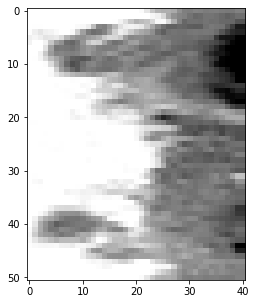

In [8]:
# Visualize warped image
warped_image = WarpImage(image,X,Y,height,width)
print(warped_image.shape)

%matplotlib inline
fig=plt.figure(figsize=(5, 5))
plt.imshow(warped_image.detach().cpu(),cmap='gray')
plt.show()


## Change "DynProg" to "DynProg_vectorized" to test your vectorized DP code. Do not edit anything else in the next cell.



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


torch.Size([50])
tensor([27, 27, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 24, 25,
        26, 27, 27, 29, 28, 29, 27, 25, 23, 24, 24, 24, 24, 23, 23, 22, 22, 22,
        22, 22, 22, 21, 21, 22, 23, 24, 25, 25, 26, 28, 28, 27],
       device='cuda:0')


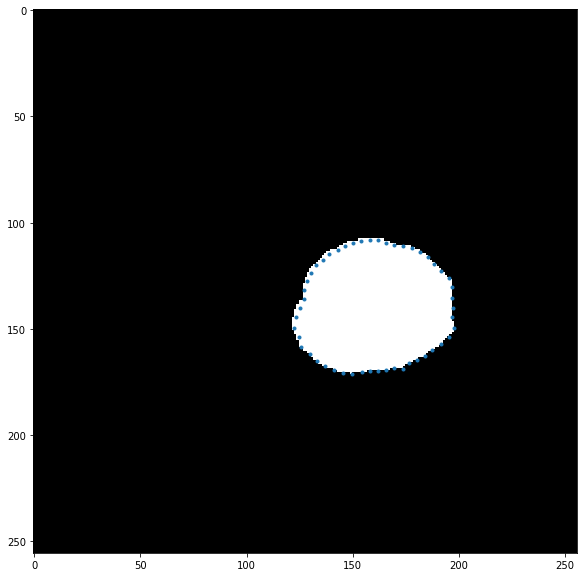

In [9]:
# test dynamic programming and create target label
with torch.no_grad():
  warped_label_image = WarpImage(label_image,X,Y,height,width)
  target = DynProg_vectorized(U,I,E,v,warped_label_image,N,M,delta).clone() # clone to not corrupt it

print(target.shape)
print(target)

target_x=np.zeros((N))
target_y=np.zeros((N))
for n in range(N):
  target_x[n] = X[n,target[n]]  
  target_y[n] = Y[n,target[n]]

%matplotlib inline
fig=plt.figure(figsize=(10, 10))
plt.imshow(label_image.detach().cpu(),cmap='gray')
plt.plot(target_x,target_y,'.')
plt.show()


## Edit next cell to write your optimization (training) code. This section should implement Algorithm 2 from https://arxiv.org/abs/1812.00328. To get credit for this portion, on Google colaboratory with the GPU option this training code must run within 3 minutes.

In [18]:
import time
# Your training code. This should implement Algorithm 2 from https://arxiv.org/abs/1812.00328
# You might have to make use of torch.no_grad() or something equivalent in relevant places
##############################
t0 = time.time()
learning_rate = 1e-3 # an example value
sig = 1.0 # an example value, this is for jittering input to approximating net and dynamic program
step = 1
epochs =200
S=10
theta=0.5
radius =65

################################################################## defining the approximate and CNN network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().cuda()
snake_approx_net = ApproxNet().cuda()

########################### defining the optimizers

optimizer = torch.optim.Adam(params=net.parameters(), lr= 1e-3 )
snake_approx_optimizer = torch.optim.Adam(params=snake_approx_net.parameters(), lr= 1e-3)

###############################

for epoch in range(1,epochs):

    ###########################training the CNN network

    xs = torch.cuda.FloatTensor(image)
    net.train()
    CNN_output = net(xs.unsqueeze(0).unsqueeze(1)) 

    #######################loss
    loss = nn.CrossEntropyLoss().cuda()

    for i in range (0,S,1):

            ###################adding noise to the output of CNN

            CNN_output_warped = WarpImage(CNN_output.squeeze(1).squeeze(0),X,Y,height,width)
            jittering_matrix = torch.empty((51,41)).normal_(mean=0,std=1).cuda()
            jittered_image = CNN_output_warped + jittering_matrix

            ##################change the dimensions to 50 by 50

            jittered_image_50_41 = jittered_image[:, 1:] - jittered_image[:, :-1]  
            jittered_image_50_40 = jittered_image_50_41[1:,:] - jittered_image_50_41[:-1,:]

            #####################
            with torch.no_grad():
                first_target = DynProg_vectorized(U,I,E,v,jittered_image,N,M,delta).clone() # clone to not corrupt it
            first_target = DynProg_vectorized(U,I,E,v,jittered_image,N,M,delta)
            snake_approx_net.train()
            prediction = snake_approx_net(jittered_image_50_40.unsqueeze(0).unsqueeze(1).to(device).float())
            snake_approx_train_loss= loss( prediction.squeeze(1).squeeze(0),first_target )
            snake_approx_optimizer.zero_grad()
            snake_approx_train_loss.backward(retain_graph=True)
            snake_approx_optimizer.step()

    ##############

    CNN_output_warped_50_41 = CNN_output_warped[:, 1:] - CNN_output_warped[:, :-1]  
    CNN_output_warped_50_40 = CNN_output_warped_50_41[1:,:] - CNN_output_warped_50_41[:-1,:]

    ############

    target = DynProg_vectorized(U,I,E,v,warped_label_image,N,M,delta)
    total_loss = loss(CNN_output_warped_50_40, target)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


elapsed = time.time() - t0
print(elapsed, "is the running time in seconds")      


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


164.4671938419342 is the running time in seconds


## Do not edit next cell

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


tensor([29, 30, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 25, 25,
        23, 23, 25, 26, 28, 29, 27, 25, 23, 24, 24, 22, 21, 23, 22, 22, 21, 21,
        20, 20, 20, 21, 21, 21, 23, 24, 25, 26, 27, 28, 27, 27],
       device='cuda:0')
tensor([29, 30, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 25, 25,
        23, 23, 25, 26, 28, 29, 27, 25, 23, 24, 24, 22, 21, 23, 22, 22, 21, 21,
        20, 20, 20, 21, 21, 21, 23, 24, 25, 26, 27, 28, 27, 27],
       device='cuda:0')


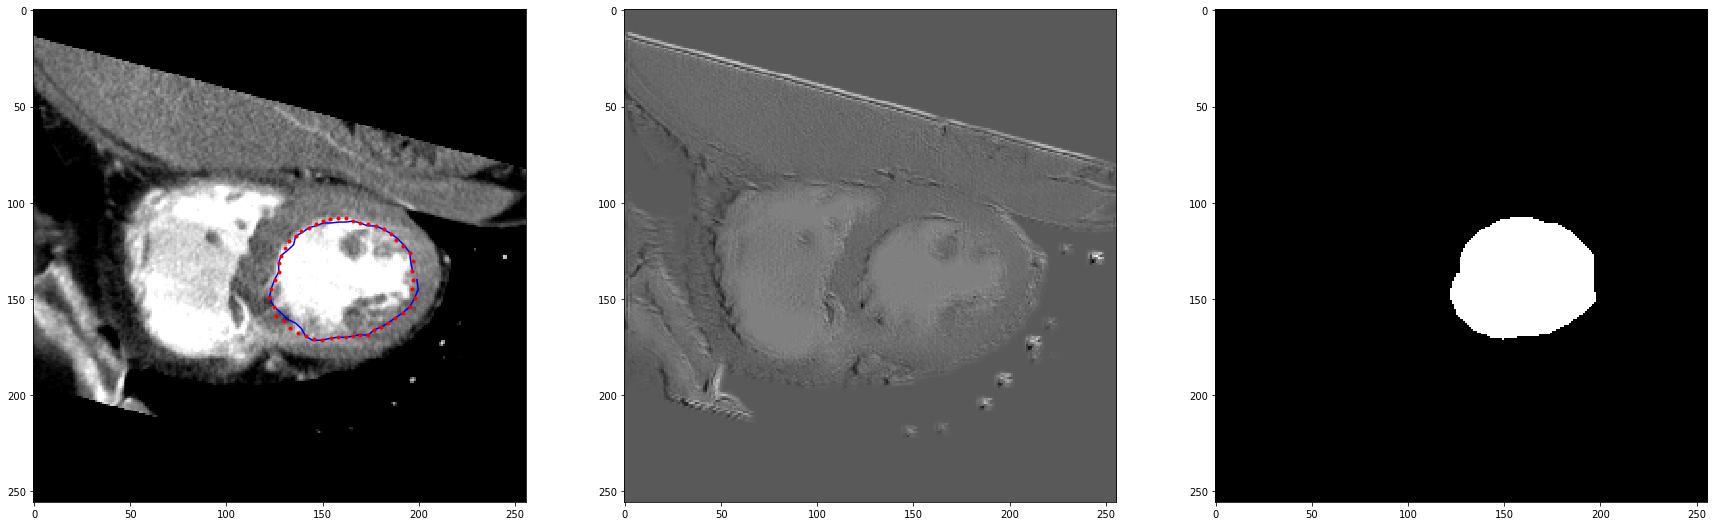

In [19]:
# showtime!
im_out = net(image.view(1,1,height,width)).squeeze()
warped_image = WarpImage(im_out,X,Y,height,width)
ind = DynProg_vectorized(U,I,E,v,warped_image,N,M,delta).clone()
print(ind)
print(target)
x=np.zeros((N))
y=np.zeros((N))
for n in range(N):
  x[n] = X[n,ind[n]]  
  y[n] = Y[n,ind[n]]

%matplotlib inline
fig=plt.figure(figsize=(30, 30))
plt.subplot(1,3,1)
plt.imshow(image.view(height,width).detach().cpu().numpy(),cmap='gray')
plt.plot(x,y,'b')
plt.plot(target_x,target_y,'r.')

plt.subplot(1,3,2)
plt.imshow(im_out.view(height,width).detach().cpu().numpy(),cmap='gray')

plt.subplot(1,3,3)
plt.imshow(label_image.view(height,width).detach().cpu().numpy(),cmap='gray')

plt.show()

#PART(B)


Dynamic Programming can be used to perform energy minimization and correspondingly detect contours, lines, and boundaries in medical image analysis. Using this method in a left ventricle segmentation task is an exceptional approach due to its capability to find the global optimum and producing a connected and continuous contour despite the existence of inhomogeneities and holes in the original image. In this approach shortest path search utilizing energy minimization is the main task that mostly represents considerably less computation cost and processing time compared to other similar short path search algorithms. It is worth mentioning, having a vectorized form is the deterministic factor that decreases the computation cost and according to [1], the efficiency alteration is the difference between O( k^n ) to O( ( k^2 )n). The optimized nature of EDPCNN has been shown us a very promising result compared to the vanilla U-NET when the number of samples in the training dataset is limited. Notably, the rate of progress in estimated accuracy for U-NET is better for the higher number of samples. However, EDPCNN has been shown superior performance over U-Net in this task with the same number of samples in the training data set. Also, this model is very robust with respect to the position of the star pattern center.  
The main disadvantage of this model is the existence of non-differentiable loss function argmin inside the dynamic programming that has been solved by using an approximate neural network to mimic the output of DP. It is notable that sometimes the output after visualizing is jagged and sharp that is caused by the nature of the algorithm that uses a limited number of radial lines while implementing starpattern function. Moreover, training time is 16% higher than U-NET is a little bit challenging for huge datasets.   






#Refrences
[1] Dynamic Programming Based Segmentation in Biomedical Imaging, Kathrin Ungru, Xiaoyi Jiang, 2017